In [498]:
import numpy as np
!pip install pandas
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [499]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [500]:
df = pd.read_csv('dataset/fish_data.csv')
df

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31
...,...,...,...,...
4075,Sillaginopsis panijus,30.56,6.12,0.20
4076,Sillaginopsis panijus,29.66,6.11,0.21
4077,Sillaginopsis panijus,32.81,6.25,0.19
4078,Sillaginopsis panijus,29.78,6.11,0.21


In [501]:
Y, Y_labels = pd.factorize(df['species'])
Y_labels

Index(['Anabas testudineus', 'Coilia dussumieri', 'Otolithoides biauritus',
       'Otolithoides pama', 'Pethia conchonius', 'Polynemus paradiseus',
       'Puntius lateristriga', 'Setipinna taty', 'Sillaginopsis panijus'],
      dtype='object')

In [502]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(df.iloc[:, 1:])
X

array([[-0.9409222 , -0.27866241,  0.54635083],
       [-1.46806569, -0.45169987,  1.76555488],
       [-1.26142544, -0.26904922,  1.27787326],
       ...,
       [ 2.17273871,  2.41303142, -0.51029267],
       [ 1.74680677,  2.27844673, -0.34773214],
       [ 2.00545851,  2.3072863 , -0.51029267]])

In [ ]:
class KNNClassifier:
    @staticmethod
    def predict_bulk(
            x_train: np.ndarray,
            y_train: np.ndarray,
            x_test: np.ndarray,
            y_test: np.ndarray,
            class_count: int,
            k: int
    ) -> np.ndarray:
        confusion_matrix = np.zeros((class_count, class_count), dtype=np.uint)
        for idx, (x_predictable, y_predictable) in enumerate(zip(x_test, y_test)):
            distances = np.linalg.norm(x_predictable[np.newaxis, :] - x_train, axis=1)
            nearest_indices = np.argsort(distances)[:k + 1]
            nearest_distances = distances[nearest_indices]
            nuclear_distances = np.exp(- (1 / 2) * nearest_distances[:k] / nearest_distances[k])
            nearest_classes = y_train[nearest_indices[:k]]
            class_powers = np.bincount(nearest_classes, weights=nuclear_distances)
            nearest_class = np.argmax(class_powers)
            confusion_matrix[y_predictable, nearest_class] += 1
        return confusion_matrix

    @staticmethod
    def predict(
            x_train: np.ndarray,
            y_train: np.ndarray,
            x_predictable: np.array,
            k: int
    ):
        distances = np.linalg.norm(x_predictable[np.newaxis, :] - x_train, axis=1)
        nearest_indices = np.argsort(distances)[:k + 1]
        nearest_distances = distances[nearest_indices]
        nuclear_distances = np.exp(- (1 / 2) * nearest_distances[:k] / nearest_distances[k])
        nearest_classes = y_train[nearest_indices[:k]]
        class_powers = np.bincount(nearest_classes, weights=nuclear_distances)
        return np.argmax(class_powers)


confusion_matrix = KNNClassifier.predict_bulk(X, Y, X, Y, len(Y_labels), 203)
confusion_matrix

leave-one-out

In [528]:
# LOO
n = len(X)
start_k, finish_k = 3, 200
biased = np.zeros(shape=(finish_k,))
biased[:start_k] = np.nan
unbiased = np.zeros(shape=(finish_k,))
unbiased[:start_k] = np.nan
for k in range(start_k, finish_k):
    for idx in np.arange(X.shape[0]):
        biased_predicted_y = KNNClassifier.predict(
            x_train=np.delete(X, idx, axis=0),
            y_train=np.delete(Y, idx, axis=0),
            x_predictable=X[idx],
            k=k
        )
        if biased_predicted_y != Y[idx]:
            biased[k] += 1
        unbiased_predicted_y = KNNClassifier.predict(
            x_train=X,
            y_train=Y,
            x_predictable=X[idx],
            k=k
        )
        if unbiased_predicted_y != Y[idx]:
            unbiased[k] += 1
evaluates = pd.DataFrame({
    'biased': biased / n,
    'unbiased': unbiased / n
})
evaluates

,biased,unbiased
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,0.067647,0.035539
4,0.070098,0.024510
...,...,...
195,0.068137,0.066667
196,0.067892,0.066912
197,0.067892,0.066667
198,0.067892,0.067402


<module 'matplotlib.pyplot' from '/home/trisolaris/projects/magisters/MLAlgorithm/.venv/lib64/python3.12/site-packages/matplotlib/pyplot.py'>

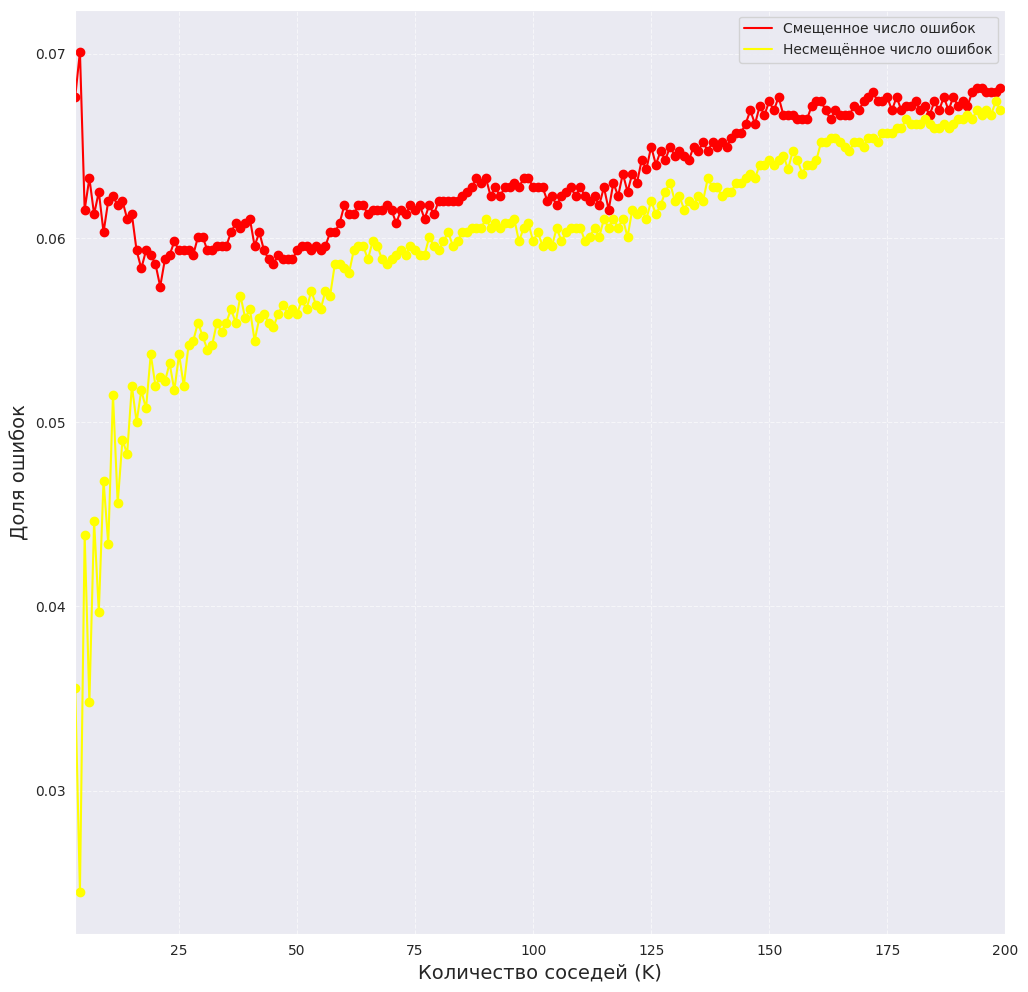

In [541]:
plt.figure(figsize=(12, 12))
plt.xlabel('Количество соседей (K)', fontsize=14)
plt.ylabel('Доля ошибок', fontsize=14)
plt.grid(True, which='both',linestyle='--', alpha=0.6,)
plt.plot(np.arange(start_k, finish_k, dtype=np.uint), evaluates['biased'][start_k:], color='red', label='Смещенное число ошибок')
plt.plot(np.arange(start_k, finish_k, dtype=np.uint), evaluates['unbiased'][start_k:], color='yellow', label='Несмещённое число ошибок')
plt.xlim(start_k, finish_k)
plt.scatter(np.arange(start_k, finish_k, dtype=np.uint), evaluates['biased'][start_k:], color='red',label='_')
plt.scatter(np.arange(start_k, finish_k, dtype=np.uint), evaluates['unbiased'][start_k:], color='yellow',label='_')
plt.legend()

plt

In [507]:
n = len(X)
start_k, finish_k = 3, 200
empirical_risks = np.zeros(shape=(finish_k,))
for k in range(start_k, finish_k):
    confusion_matrix = KNNClassifier.predict_bulk(X, Y, X, Y, len(Y_labels), k)
    empirical_risks[k] = (np.sum(confusion_matrix) - np.trace(confusion_matrix)) / np.sum(confusion_matrix)
empirical_risks

array([0.        , 0.        , 0.        , 0.03553922, 0.0245098 ,
       0.04387255, 0.03480392, 0.04460784, 0.03970588, 0.04681373,
       0.04338235, 0.05147059, 0.04558824, 0.04901961, 0.04828431,
       0.05196078, 0.05      , 0.05171569, 0.05073529, 0.05367647,
       0.05196078, 0.05245098, 0.05220588, 0.05318627, 0.05171569,
       0.05367647, 0.05196078, 0.05416667, 0.05441176, 0.05539216,
       0.05465686, 0.05392157, 0.05416667, 0.05539216, 0.05490196,
       0.05539216, 0.05612745, 0.05539216, 0.05686275, 0.05563725,
       0.05612745, 0.05441176, 0.05563725, 0.05588235, 0.05539216,
       0.05514706, 0.05588235, 0.05637255, 0.05588235, 0.05612745,
       0.05588235, 0.05661765, 0.05612745, 0.05710784, 0.05637255,
       0.05612745, 0.05710784, 0.05686275, 0.05857843, 0.05857843,
       0.05833333, 0.05808824, 0.05931373, 0.05955882, 0.05955882,
       0.05882353, 0.05980392, 0.05955882, 0.05882353, 0.05857843,
       0.05882353, 0.05906863, 0.05931373, 0.05906863, 0.05955

<module 'matplotlib.pyplot' from '/home/trisolaris/projects/magisters/MLAlgorithm/.venv/lib64/python3.12/site-packages/matplotlib/pyplot.py'>

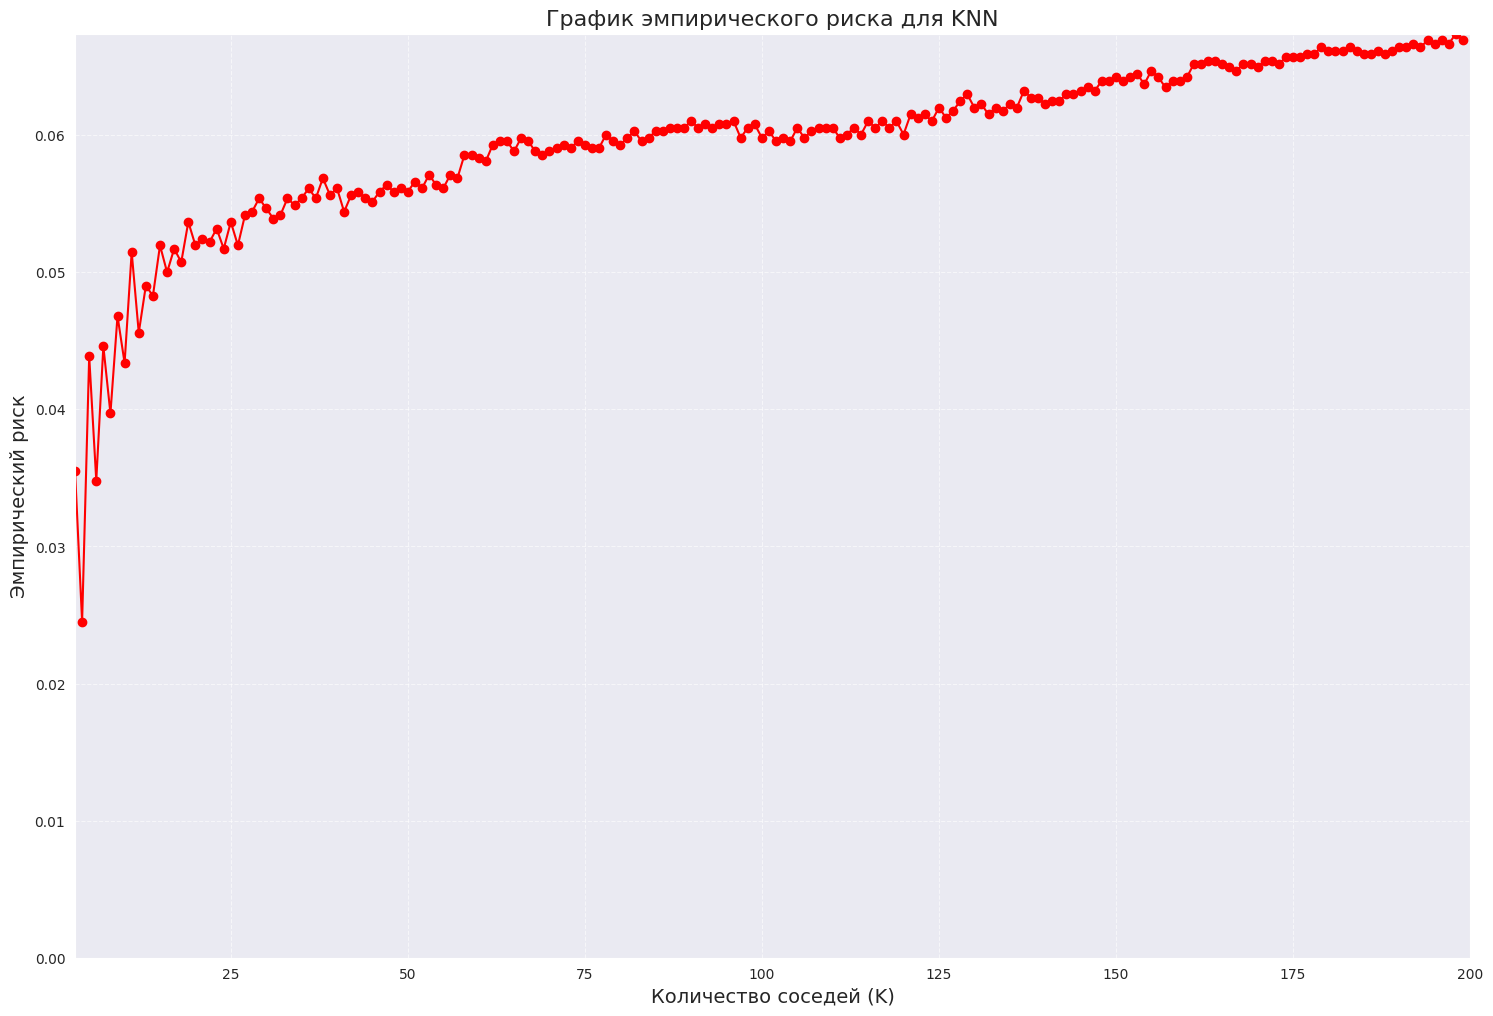

In [508]:
plt.figure(figsize=(18, 12))

plt.xlabel('Количество соседей (K)', fontsize=14)
plt.ylabel('Эмпирический риск', fontsize=14)
plt.title('График эмпирического риска для KNN', fontsize=16)
plt.grid(True, which='both',linestyle='--', alpha=0.6,)

plt.plot(np.arange(start_k, finish_k, dtype=np.uint), empirical_risks[start_k:], color='red')
plt.xlim(start_k, finish_k)
plt.ylim(0, empirical_risks.max())
plt.scatter(np.arange(start_k, finish_k, dtype=np.uint), empirical_risks[start_k:], color='red')

plt

In [519]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=40)

knn.fit(X, Y)

y_predict = knn.predict(X)

accuracy = accuracy_score(Y, y_predict, )
accuracy

0.9443627450980392

In [527]:
confusion_matrix = KNNClassifier.predict_bulk(X, Y, X, Y, len(Y_labels), 40)
np.trace(confusion_matrix) / np.sum(confusion_matrix)


np.float64(0.9438725490196078)

In [520]:
%timeit knn.predict(X)

89 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [521]:
%timeit KNNClassifier.predict_bulk(X, Y, X, Y, len(Y_labels), 40)

305 ms ± 4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
